In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2022-08-03 19:10:21.868722: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Load Cifar-10 data-set
(train_im, train_lab), (test_im, test_lab) = tf.keras.datasets.cifar10.load_data()

In [3]:
#### Normalize the images to pixel values (0, 1)
train_im, test_im = train_im/255.0 , test_im/255.0
#### Check the format of the data 
print ("train_im, train_lab types: ", type(train_im), type(train_lab))
#### check the shape of the data
print ("shape of images and labels array: ", train_im.shape, train_lab.shape) 
print ("shape of images and labels array ; test: ", test_im.shape, test_lab.shape)

train_im, train_lab types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape of images and labels array:  (50000, 32, 32, 3) (50000, 1)
shape of images and labels array ; test:  (10000, 32, 32, 3) (10000, 1)


In [4]:
#### Check the distribution of unique elements 
(unique, counts) = np.unique(train_lab, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print (frequencies)
print (len(unique))

[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]
10


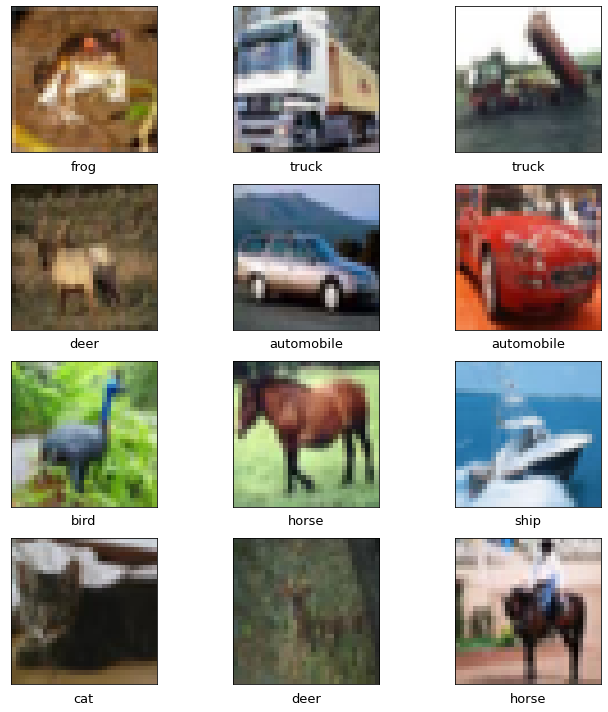

In [5]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] # from cifar-10 website

plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_im[i], cmap='gray')
    plt.xlabel(class_types[train_lab[i][0]], fontsize=13)
plt.tight_layout()
plt.show()

In [6]:
### One hot encoding for labels 

train_lab_categorical = tf.keras.utils.to_categorical(
    train_lab, num_classes=10, dtype='uint8')

test_lab_categorical = tf.keras.utils.to_categorical(
    test_lab, num_classes=10, dtype='uint8')

In [7]:
### Train -test split 

from sklearn.model_selection import train_test_split 
train_im, valid_im, train_lab, valid_lab = train_test_split(train_im, train_lab_categorical, test_size=0.20, 
                                                            stratify=train_lab_categorical, 
                                                            random_state=40, shuffle = True)

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (40000, 32, 32, 3)
new validation data shape:  (10000, 32, 32, 3)
validation labels shape:  (10000, 10)


In [8]:
#### Necessary Imports for Neural Net 

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [9]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [10]:
def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [11]:
def resnet50():

  input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [12]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr

lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  

In [13]:
resnet50_model = resnet50()

2022-07-26 09:38:11.327900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 09:38:11.419333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 09:38:11.419719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 09:38:11.420572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [14]:
resnet50_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

 conv2d_10 (Conv2D)             (None, 7, 7, 256)    16640       ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 7, 7, 256)   1024        ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_2 (Add)                    (None, 7, 7, 256)    0           ['batch_normalization_10[0][0]', 
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 7, 7, 256)    0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_11

                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 4, 4, 512)    0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_21 (Conv2D)             (None, 4, 4, 128)    65664       ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 4, 4, 128)   512         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 4, 4, 128)    0           ['batch_normalization_21[0][0]'] 
          

 batch_normalization_31 (BatchN  (None, 2, 2, 256)   1024        ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_28 (Activation)     (None, 2, 2, 256)    0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 2, 2, 256)    590080      ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_32 (BatchN  (None, 2, 2, 256)   1024        ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_42 (Conv2D)             (None, 2, 2, 1024)   263168      ['activation_38[0][0]']          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 2, 2, 1024)  4096        ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_12 (Add)                   (None, 2, 2, 1024)   0           ['batch_normalization_42[0][0]', 
                                                                  'activation_36[0][0]']          
                                                                                                  
 activation_39 (Activation)     (None, 2, 2, 1024)   0           ['add_12[0][0]']                 
          

 add_15 (Add)                   (None, 1, 1, 2048)   0           ['batch_normalization_52[0][0]', 
                                                                  'activation_45[0][0]']          
                                                                                                  
 activation_48 (Activation)     (None, 1, 1, 2048)   0           ['add_15[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 2048)  0           ['activation_48[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense (De

In [15]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [16]:
##### Data Augmentation/Data Flow, need to modify during FFT
batch_size = 64

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator()
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(train_im, train_lab, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(valid_im, valid_lab, batch_size=batch_size) # so as valid_lab 

In [17]:
batch_size=batch_size # test with 64, 128, 256

resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=160, 
                                  steps_per_epoch=train_im.shape[0]/batch_size, 
                                  validation_steps=valid_im.shape[0]/batch_size, 
                                  validation_data=valid_set_conv, 
                                  callbacks=[lrdecay])

Epoch 1/160


2022-07-26 09:38:20.346590: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-07-26 09:38:22.627918: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


625/625 [==============================] - 44s 54ms/step - loss: 15.0004 - acc: 0.3657 - val_loss: 13.1230 - val_acc: 0.1445 - lr: 0.0010
Epoch 2/160
625/625 [==============================] - 33s 52ms/step - loss: 8.3063 - acc: 0.4078 - val_loss: 7.6260 - val_acc: 0.3032 - lr: 0.0010
Epoch 3/160
625/625 [==============================] - 33s 53ms/step - loss: 5.6229 - acc: 0.4304 - val_loss: 4.7410 - val_acc: 0.3928 - lr: 0.0010
Epoch 4/160
625/625 [==============================] - 32s 51ms/step - loss: 4.2127 - acc: 0.4693 - val_loss: 4.0611 - val_acc: 0.3494 - lr: 0.0010
Epoch 5/160
625/625 [==============================] - 31s 50ms/step - loss: 3.8496 - acc: 0.4329 - val_loss: 3.2074 - val_acc: 0.4340 - lr: 0.0010
Epoch 6/160
625/625 [==============================] - 31s 50ms/step - loss: 4.2609 - acc: 0.3909 - val_loss: 3.4300 - val_acc: 0.3558 - lr: 0.0010
Epoch 7/160
625/625 [==============================] - 31s 49ms/step - loss: 3.3758 - acc: 0.4352 - val_loss: 5.7014 - val

625/625 [==============================] - 33s 52ms/step - loss: 0.7164 - acc: 0.8756 - val_loss: 1.3901 - val_acc: 0.6979 - lr: 0.0010
Epoch 57/160
625/625 [==============================] - 33s 52ms/step - loss: 0.7107 - acc: 0.8774 - val_loss: 1.4385 - val_acc: 0.6910 - lr: 0.0010
Epoch 58/160
625/625 [==============================] - 33s 52ms/step - loss: 0.6968 - acc: 0.8826 - val_loss: 1.3810 - val_acc: 0.6927 - lr: 0.0010
Epoch 59/160
625/625 [==============================] - 33s 52ms/step - loss: 0.6998 - acc: 0.8804 - val_loss: 1.3857 - val_acc: 0.6988 - lr: 0.0010
Epoch 60/160
625/625 [==============================] - 32s 52ms/step - loss: 0.7009 - acc: 0.8834 - val_loss: 1.4286 - val_acc: 0.7012 - lr: 0.0010
Epoch 61/160
625/625 [==============================] - 33s 53ms/step - loss: 0.6865 - acc: 0.8856 - val_loss: 1.5933 - val_acc: 0.6853 - lr: 0.0010
Epoch 62/160
625/625 [==============================] - 33s 53ms/step - loss: 0.6872 - acc: 0.8881 - val_loss: 1.3673 -

In [18]:
resnet50_model.save("Model")

INFO:tensorflow:Assets written to: Model/assets


INFO:tensorflow:Assets written to: Model/assets


In [3]:
import cv2
from tensorflow.signal import fft2d, ifft2d
from tensorflow.math import real, imag

In [ ]:
# Have to create a single data point for the images :think:
"""
[image number] 
[ [red_real][red_img] ] 
[ [blue_real][blue_img] ]
[ [green_real][green_img] ]
"""

In [15]:
"""
Go through every image
Do FFT
Now we have single Image FFT thingy
RGB can be stacked first like above (Using brackets)
Everything can be appended to a master array
"""

In [9]:
train_im.shape[0]

50000

In [17]:
train_fft = []

In [18]:
for i in range(len(train_im)):
    b, g, r = cv2.split(train_im[i])
    b_fft, g_fft, r_fft = fft2d(b), fft2d(g), fft2d(r)
    train_fft.append([[real(r_fft) , imag(r_fft)], [real(g_fft) , imag(g_fft)], [real(b_fft) , imag(b_fft)]])

In [19]:
train_fft = tf.constant(train_fft)

ValueError: TypeError: Scalar tensor has no `len()`
Traceback (most recent call last):

  File "/home/venom/miniconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1106, in __len__
    raise TypeError("Scalar tensor has no `len()`")

TypeError: Scalar tensor has no `len()`



In [48]:
type(train_fft)

numpy.ndarray

In [43]:
tf.shape(train_im[0])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([32, 32,  3], dtype=int32)>

In [17]:
from tensorflow.signal import fft2d, ifft2d
from tensorflow.math import real, imag

In [18]:
b_train_real = real(b_train)
r_train_real = real(r_train)
g_train_real = real(g_train)

b_train_imag = imag(b_train)
r_train_imag = imag(r_train)
g_train_imag = imag(g_train)

2022-08-03 18:44:52.614799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 18:44:52.664096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 18:44:52.664240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 18:44:52.665422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [ ]:
def resnet50_fft():

  input_im = Input(shape=(train_fft.shape[1], train_fft.shape[2], train_fft.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model